<a href="https://colab.research.google.com/github/ol287/Learning_from_data_cw/blob/main/Learning_front_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Error reading the file: [Errno 2] No such file or directory: '/content/sample_data/TSLA.csv'


<ipython-input-3-90619578c90e>:53: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


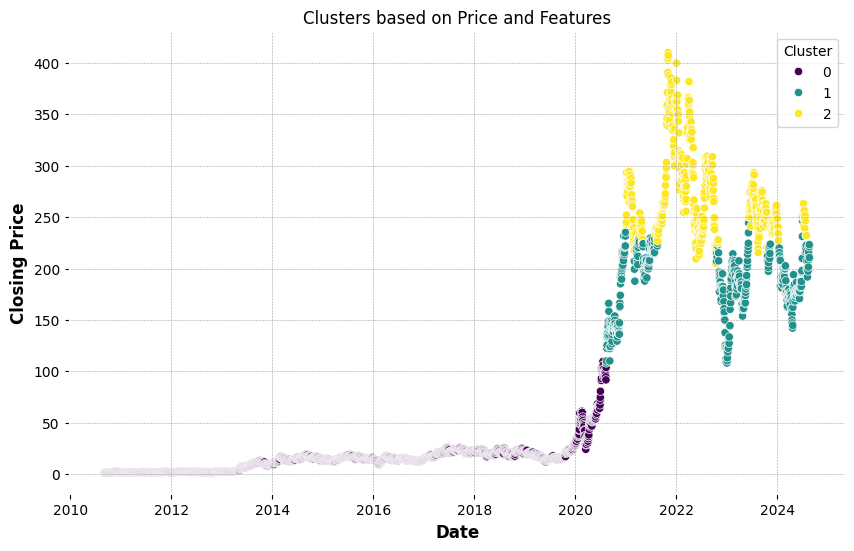

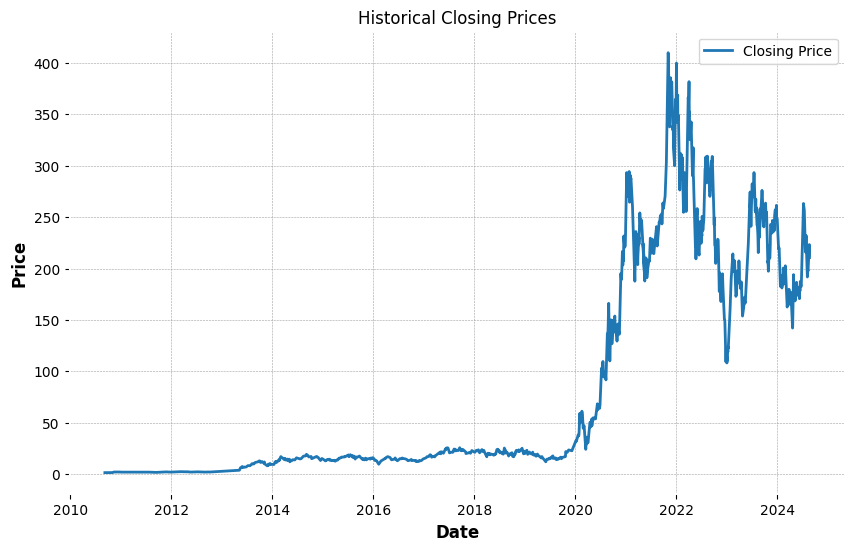

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


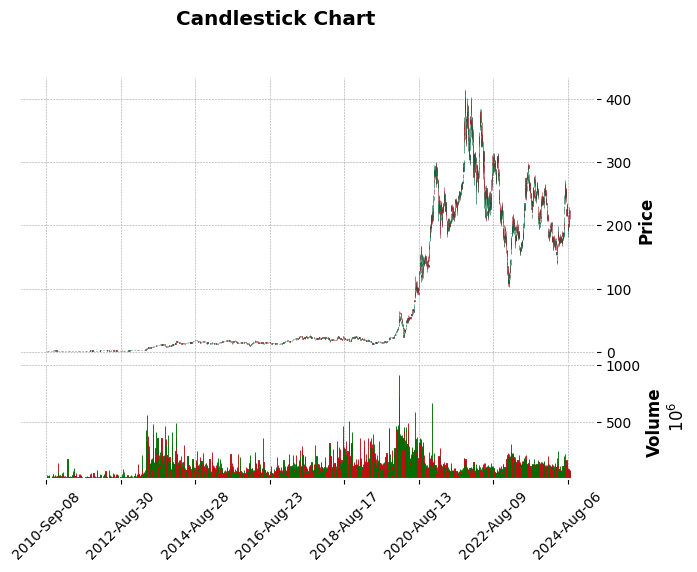

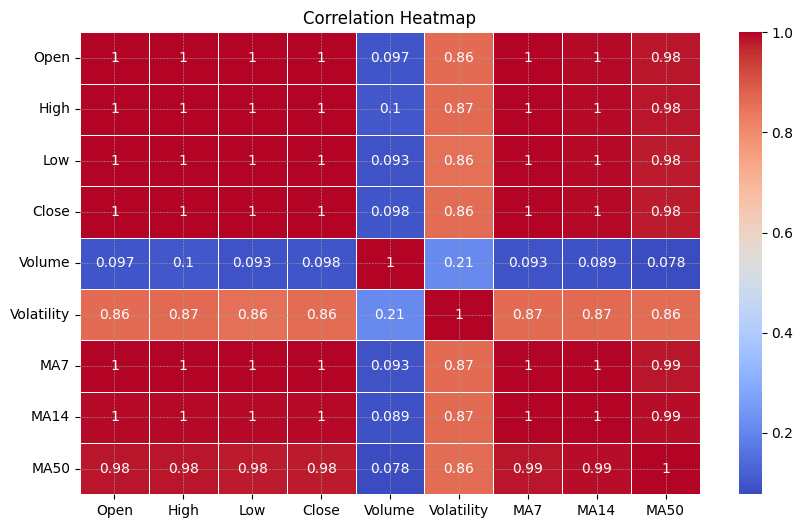

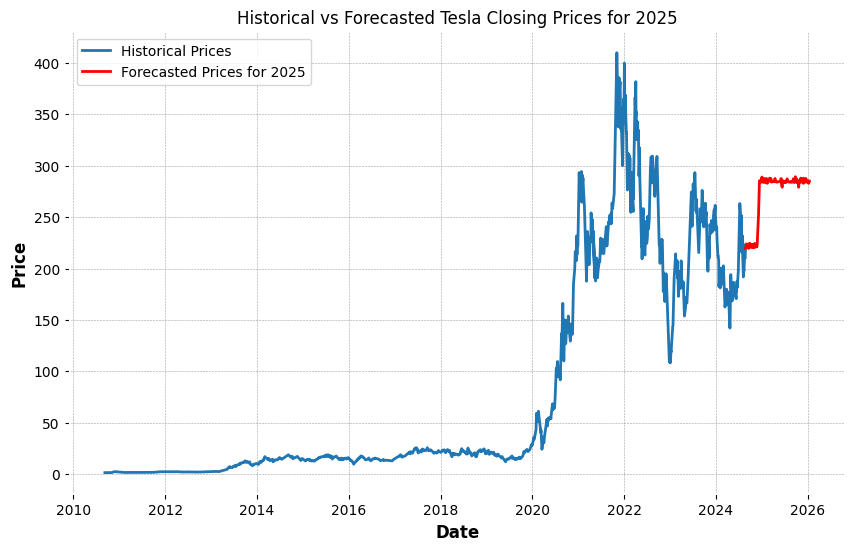

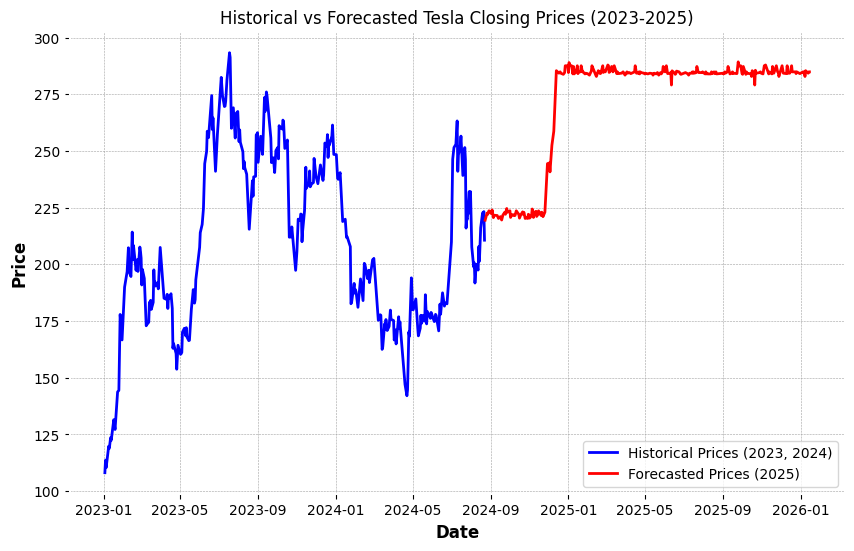

           Date       Close
3561 2024-08-23  219.470673
3561 2024-08-26  222.585007
3561 2024-08-27  222.015472
3561 2024-08-28  222.933472
3561 2024-08-29  223.626160
...         ...         ...
3561 2026-01-09  285.422699
3561 2026-01-12  284.900635
3561 2026-01-13  284.310730
3561 2026-01-14  284.900635
3561 2026-01-15  284.900635

[365 rows x 2 columns]


In [3]:
# Install necessary libraries
!pip install mplfinance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans

# Load the CSV file

def convert_file_to_csv(input_file_path, output_file_path):
    try:
        # Attempt to read the file with pandas
        df = pd.read_csv(input_file_path, encoding='utf-8')
        # Print the first 5 rows of the DataFrame
        print(df.head())
    except Exception as e:
        print("Error reading the file:", e)
        return

    try:
        # Save the DataFrame to a new CSV file
        df.to_csv(output_file_path, index=False)
        print(f"File successfully saved to {output_file_path}")
    except Exception as e:
        print("Error saving the file as CSV:", e)

# Specify the path to your file
input_path = '/content/sample_data/TSLA.csv'
output_path = '/content/sample_data/Tesla2.csv'

# Convert the file
convert_file_to_csv(input_path, output_path)
file_path = '/content/sample_data/Tesla2.csv'
df = pd.read_csv(file_path)

# ------------------- 1. Data Preprocessing -------------------

# Remove currency symbols from price columns and convert to numeric
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Close'] = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(int)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Handle missing values by filling them with the mean of each column
df.fillna(df.mean(), inplace=True)

# ------------------- Feature Engineering -------------------

# Create daily volatility feature
df['Volatility'] = df['High'] - df['Low']

# Create moving averages
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA14'] = df['Close'].rolling(window=14).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Create lag features for closing prices
df['Lag1'] = df['Close'].shift(1)
df['Lag2'] = df['Close'].shift(2)

# Drop rows with NaN values due to moving averages or lag features
#data cleansing
df.dropna(inplace=True)

# Scale the 'Volume' column using StandardScaler
scaler = StandardScaler()
df['Volume_Scaled'] = scaler.fit_transform(df[['Volume']])

# ------------------- 2. Clustering -------------------

# Select features for clustering
clustering_features = ['High', 'Low', 'Close', 'Volume_Scaled', 'Volatility', 'MA7', 'MA14', 'MA50']

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # You can change the number of clusters if needed
df['Cluster'] = kmeans.fit_predict(df[clustering_features])

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Date'], y=df['Close'], hue=df['Cluster'], palette='viridis')
plt.title('Clusters based on Price and Features')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

# ------------------- 3. Exploratory Data Analysis (EDA) -------------------

# Plot historical closing prices
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price')
plt.title('Historical Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# ------------------- Candlestick Chart -------------------

# Prepare data for candlestick chart
df_candlestick = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df_candlestick.set_index('Date', inplace=True)

# Plot candlestick chart using mplfinance
mpf.plot(df_candlestick, type='candle', volume=True, style='charles', title='Candlestick Chart', ylabel='Price', ylabel_lower='Volume')

# ------------------- Heatmap of Correlations -------------------

# Calculate correlation matrix
corr_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Volatility', 'MA7', 'MA14', 'MA50']].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# ------------------- 4. Modeling -------------------

# Define features (X) and target (y)
features = ['High', 'Low', 'Volume_Scaled', 'Volatility', 'MA7', 'MA14', 'MA50', 'Lag1', 'Lag2']
X = df[features]
y = df['Close']

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Regressor
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# ------------------- 5. Forecasting Future Data (for 2025) -------------------

def forecast_prices_for_2025(model, df, days_ahead=365):
    # Get the last available date and extend it into the future
    last_date = df['Date'].max()
    future_dates = pd.date_range(last_date, periods=days_ahead + 1, freq='B')[1:]  # Business days only

    # Use the last known data as the starting point for the forecast
    last_row = df.iloc[-1].copy()

    forecasted_data = []

    for future_date in future_dates:
        # Create new row and future features based on previous predictions
        new_row = last_row.copy()
        new_row['Date'] = future_date

        # Update moving averages dynamically using forecasted data
        last_close_values = [last_row['Lag1'], last_row['Close']]
        new_row['MA7'] = np.mean(last_close_values[-7:]) if len(last_close_values) >= 7 else np.mean(last_close_values)
        new_row['MA14'] = np.mean(last_close_values[-14:]) if len(last_close_values) >= 14 else np.mean(last_close_values)
        new_row['MA50'] = np.mean(last_close_values[-50:]) if len(last_close_values) >= 50 else np.mean(last_close_values)

        # Lag features (e.g., Lag1, Lag2)
        new_row['Lag1'] = last_row['Close']
        new_row['Lag2'] = last_row['Lag1']

        # Predict the next day's price using the model
        X_new = pd.DataFrame([new_row[features]])
        predicted_close = model.predict(X_new)[0]

        # Append new row for forecast
        new_row['Close'] = predicted_close
        forecasted_data.append(new_row)

        # Update last row to simulate moving forward in time
        last_row['Close'] = predicted_close
        last_row['Lag1'] = new_row['Close']
        last_row['Lag2'] = new_row['Lag1']
        last_row['High'] = predicted_close * (1 + np.random.normal(0, 0.01))  # Add slight randomness to High
        last_row['Low'] = predicted_close * (1 - np.random.normal(0, 0.01))  # Add slight randomness to Low

    # Convert the forecasted data into a DataFrame
    forecast_df = pd.DataFrame(forecasted_data)

    return forecast_df

# Example: Predict for 2025 using the XGBoost model
forecast_df = forecast_prices_for_2025(xgb, df, days_ahead=365)

# Plot the historical vs forecasted closing prices
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Historical Prices')
plt.plot(forecast_df['Date'], forecast_df['Close'], label='Forecasted Prices for 2025', color='r')
plt.title('Historical vs Forecasted Tesla Closing Prices for 2025')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# ------------------- Plot for Years 2023, 2024, and 2025 -------------------

# Filter the data for years 2023, 2024, and 2025
df_filtered = df[df['Date'].dt.year >= 2023]
forecast_df_filtered = forecast_df[forecast_df['Date'].dt.year >= 2023]

# Plot the historical vs forecasted closing prices for 2023, 2024, and 2025
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['Date'], df_filtered['Close'], label='Historical Prices (2023, 2024)', color='b')
plt.plot(forecast_df_filtered['Date'], forecast_df_filtered['Close'], label='Forecasted Prices (2025)', color='r')
plt.title('Historical vs Forecasted Tesla Closing Prices (2023-2025)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Show the forecasted prices for 2025
print(forecast_df[['Date', 'Close']])


<ipython-input-34-b05becad6858>:12: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'])
<ipython-input-34-b05becad6858>:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Volatility'] = data['Close'].rolling(window=20).std().fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
<ipython-input-34-b05becad6858>:75: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.xticks(pd.date_range(start=data['Date'].min(), end=future_dates[-1], freq='2Y'), rotation=45)


Mean Squared Error: 4035.5262025255674
R-squared Score: 0.6200593958062446


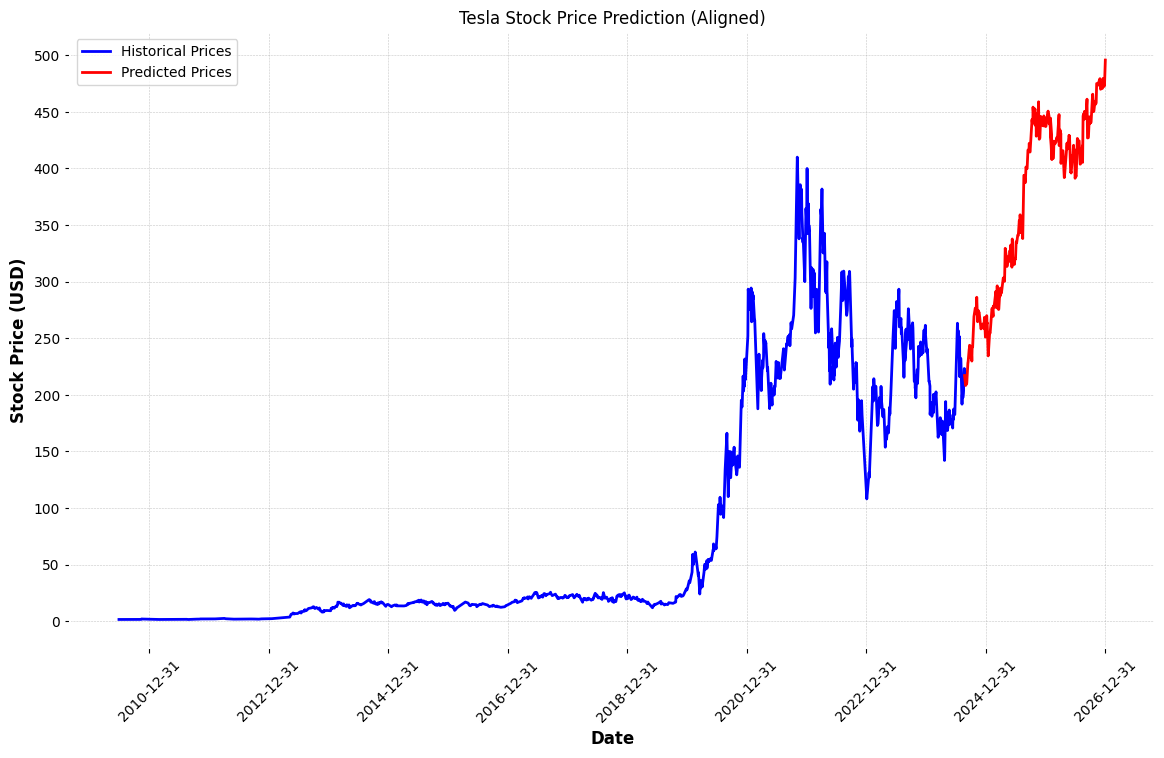

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load Tesla stock price data
data = pd.read_csv('/content/sample_data/Tesla2.csv')

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the data by date
data.sort_values('Date', inplace=True)

# Feature engineering: Create a numeric representation of the date
data['Days'] = (data['Date'] - data['Date'].min()).dt.days

# Calculate rolling volatility to simulate historical fluctuations
data['Volatility'] = data['Close'].rolling(window=20).std().fillna(method='bfill')

# Prepare the features (X) and target (y)
X = data[['Days']]
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')

# Predict future stock prices
future_dates = pd.date_range(start=data['Date'].max(), end='2026-12-31')
future_days = (future_dates - data['Date'].min()).days.to_numpy().reshape(-1, 1)

# Get the base predictions
base_future_prices = model.predict(future_days)

# Align predicted prices with the last value of historical prices
last_historical_price = data['Close'].iloc[-1]
alignment_offset = last_historical_price - base_future_prices[0]
aligned_future_prices = base_future_prices + alignment_offset

# Create random fluctuations
np.random.seed(42)  # Set seed for reproducibility
historical_volatility = data['Volatility'].values
simulated_volatility = np.random.choice(historical_volatility, size=future_days.shape[0], replace=True)

# Generate a random walk for fluctuations
random_walk = np.cumsum(np.random.normal(scale=simulated_volatility * 0.5, size=future_days.shape[0]))

# Combine aligned prices with random walk fluctuations
fluctuated_prices = aligned_future_prices + random_walk

# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(data['Date'], data['Close'], label='Historical Prices', color='blue')
plt.plot(future_dates, fluctuated_prices, label='Predicted Prices', color='red')
plt.title('Tesla Stock Price Prediction (Aligned)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')

# Add more labels to x and y axes
plt.xticks(pd.date_range(start=data['Date'].min(), end=future_dates[-1], freq='2Y'), rotation=45)
y_ticks = np.arange(0, max(data['Close'].max(), max(fluctuated_prices)) + 50, 50)
plt.yticks(y_ticks)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()
